# Eaxmple training CAE and VAE on MNIST


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from Autoencoders.encoders import Encoder2DConv, VAEEncoder2DConv
from Autoencoders.decoders import Decoder2DConv
from Autoencoders.autoencoders import Autoencoder, VAE
from Autoencoders.losses import vae_loss

from sklearn.manifold import TSNE

## Load FashionMNIST data and create a dataloader

In [2]:
"""MNIST = datasets.MNIST('./sampledata/MNIST', download=True, train=True, transform=transforms.ToTensor())
dataloader = DataLoader(MNIST, batch_size=32, num_workers=2)"""

"MNIST = datasets.MNIST('./sampledata/MNIST', download=True, train=True, transform=transforms.ToTensor())\ndataloader = DataLoader(MNIST, batch_size=32, num_workers=2)"

In [3]:
traindata = datasets.FashionMNIST('./sampledata/FashionMNIST', download=True, train=True, transform=transforms.ToTensor())
trainloader = DataLoader(traindata, batch_size=128, num_workers=8)

testdata = datasets.FashionMNIST('./sampledata/FashionMNIST', download=True, train=False, transform=transforms.ToTensor())
testloader = DataLoader(testdata, batch_size=128, num_workers=8)

In [4]:
for data, _ in trainloader:
    print(data.size())
    break

torch.Size([128, 1, 28, 28])


## Parameters

In [5]:
inputdims = (28,28)
latentdims = 32
nlayers = 2

use_cuda = True

epochs = 50

## Create the Convolutional Autoencoder (CAE)


In [12]:
cae_encoder = Encoder2DConv(inputdims, latentdims, nlayers=nlayers, use_batchnorm=True)
cae_decoder = Decoder2DConv(inputdims, latentdims, nlayers=nlayers, use_batchnorm=True)
cae = Autoencoder(cae_encoder, cae_decoder)
if use_cuda == True:
    cae = cae.cuda()
cae_loss = torch.nn.functional.mse_loss
cae_optimizer = torch.optim.Adam(cae.parameters())


## Train the CAE

Train Epoch: 0 [58880/60000 (98%)]	Loss: 8.7266106
====> Epoch: 0 Average loss: 18.3903
Train Epoch: 1 [58880/60000 (98%)]	Loss: 7.418937
====> Epoch: 1 Average loss: 8.0939
Train Epoch: 2 [58880/60000 (98%)]	Loss: 6.879416
====> Epoch: 2 Average loss: 7.2424
Train Epoch: 3 [58880/60000 (98%)]	Loss: 6.541003
====> Epoch: 3 Average loss: 6.7781
Train Epoch: 4 [58880/60000 (98%)]	Loss: 6.244746
====> Epoch: 4 Average loss: 6.4623
Train Epoch: 5 [58880/60000 (98%)]	Loss: 6.017366
====> Epoch: 5 Average loss: 6.2265
Train Epoch: 6 [58880/60000 (98%)]	Loss: 5.903792
====> Epoch: 6 Average loss: 6.0480
Train Epoch: 7 [58880/60000 (98%)]	Loss: 5.699030
====> Epoch: 7 Average loss: 5.8907
Train Epoch: 8 [58880/60000 (98%)]	Loss: 5.577741
====> Epoch: 8 Average loss: 5.7453
Train Epoch: 9 [58880/60000 (98%)]	Loss: 5.485910
====> Epoch: 9 Average loss: 5.6253
Train Epoch: 10 [58880/60000 (98%)]	Loss: 5.369335
====> Epoch: 10 Average loss: 5.5423
Train Epoch: 11 [58880/60000 (98%)]	Loss: 5.291510

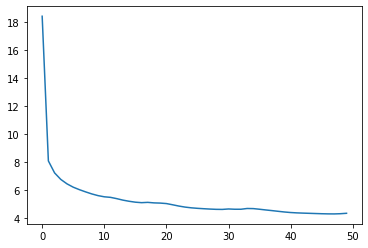

In [13]:
def train_cae(epochs):
    cae.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(trainloader):
        if use_cuda: 
            x = x.cuda()
        cae_optimizer.zero_grad()
        recon_x = cae(x)
        loss = cae_loss(recon_x, x, reduction='sum')
        loss.backward()
        train_loss += loss.item()
        cae_optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item() / len(x)),
                end="\r", flush=True)

    print('\n====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    
    return train_loss / len(trainloader.dataset)

cae_epoch_loss = []

for epoch in range(epochs):
    loss = train_cae(epoch)
    cae_epoch_loss.append(loss)
    
plt.plot(cae_epoch_loss)

## Create the Variational autoencoder (VAE)

In [14]:
#VAE
vae_encoder = VAEEncoder2DConv(inputdims, latentdims, use_batchnorm=True)
vae_decoder = Decoder2DConv(inputdims, latentdims, use_batchnorm=True)
vae = VAE(vae_encoder, vae_decoder)
if use_cuda == True:
    vae = vae.cuda()
#vae_loss is imported above
vae_optimizer = torch.optim.Adam(vae.parameters())

## Train the VAE

In [16]:
def train_vae(epochs):
    cae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, (x, _) in enumerate(trainloader):
        if use_cuda: 
            x = x.cuda()
        vae_optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss, rloss, kloss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        recon_loss += rloss.item()
        kld_loss += kloss.item()
        vae_optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRecon Loss: {:.6f}\tKLD loss: {:.6f}'.format(
                    epoch, batch_idx * len(x), 
                    len(trainloader.dataset),
                    100. * batch_idx / len(trainloader),
                    loss.item() / len(x),
                    rloss.item() / len(x),
                    kloss.item() / len(x)),
                end="\r", flush=True)

    print('\n====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    return train_loss / len(trainloader.dataset)

vae_epoch_loss = []

for epoch in range(epochs):
    loss = train_vae(epoch)
    vae_epoch_loss.append(loss)    


Train Epoch: 0 [58880/60000 (98%)]	Loss: 28.507458	Recon Loss: 20.073799	KLD loss: 8.433659
====> Epoch: 0 Average loss: 40.0647
Train Epoch: 1 [58880/60000 (98%)]	Loss: 27.237381	Recon Loss: 17.927820	KLD loss: 9.309561
====> Epoch: 1 Average loss: 28.7761
Train Epoch: 2 [58880/60000 (98%)]	Loss: 27.293039	Recon Loss: 18.394798	KLD loss: 8.898241
====> Epoch: 2 Average loss: 27.8043
Train Epoch: 3 [58880/60000 (98%)]	Loss: 26.751028	Recon Loss: 17.512848	KLD loss: 9.238180
====> Epoch: 3 Average loss: 27.1883
Train Epoch: 4 [58880/60000 (98%)]	Loss: 26.086048	Recon Loss: 17.563972	KLD loss: 8.522075
====> Epoch: 4 Average loss: 26.8169
Train Epoch: 5 [58880/60000 (98%)]	Loss: 25.960766	Recon Loss: 16.943071	KLD loss: 9.017695
====> Epoch: 5 Average loss: 26.5430
Train Epoch: 6 [58880/60000 (98%)]	Loss: 25.514214	Recon Loss: 16.706459	KLD loss: 8.807755
====> Epoch: 6 Average loss: 26.3756
Train Epoch: 7 [58880/60000 (98%)]	Loss: 25.683641	Recon Loss: 17.257690	KLD loss: 8.425951
====>

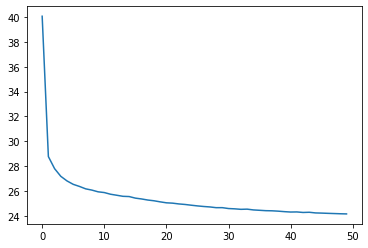

In [20]:
plt.plot(vae_epoch_loss)

In [ ]:
vae_epoch_loss